# GraphMM: Harmonize models of high-complexity

**Author: Chenxi Wang (chenxi.wang@salilab.org)**  
**Date: 2021-11-26**

A model of a complex biological system is often computed through an integrative method, for instance, [Bayesian metamodeling](https://www.biorxiv.org/content/10.1101/2021.03.29.437574v1.full.pdf), which is a divide-and-conquer modeling approach that aims to integrate heterogeneous input models into a metamodel and update knowledge. While Bayesian metamodeling can in principle be used to couple any set of input models, there are several remaining challenges. Here, we want to overcome some challenges when applying Bayesian metamodeling for more models. Selected solutions for each challenge are packed together as a new framework for practical applications of Bayesian metamodeling. More elaborated descriptions can be found in our [manuscript](https://docs.google.com/document/d/1As6r7BHpusFLq-kf93c0CriRXehjhiNq5bjUWHBo-98/edit?usp=sharing). This jupyter is a tutorial for our methods with synthetic benchmark.

## Table of Contents <a id="toc"></a>

1. [Introduction](#intro)
    1. [Bayesian metamodeling](#bayesian_metaodeling)
    2. [State space model](#state_space_model)
<br></br>
2. [A toy system of the GSIS pathway](#toy_system)
    1. [Descriptions of the toy system](#model_description)
    2. [Incorporate input models of high-complexity via Bayesian filters](#surrogate)
    3. [Couple surrogate models via a standardized and automated coupling graph](#coupling)
    4. [Multi-timescale model inference](#inference)
<br></br>    
3. [Analysis](#analysis)
    1. [Model accuracy and model precision](#model_results)
    2. [Local analysis](#local_analysis)
<br></br>    
4. [Summary and outlook](#summary)

## README

Pre-requisite:
- [Filterpy](https://filterpy.readthedocs.io/en/latest/)
- numpy
- scipy

To use our method, users need to provide:

    1. the input models, which will be converted to surrogate models using the method above
    2. the name of connecting variables, which are the selected statistically-related variables in the input models
    3. (optional) the parameters reflecting the coupling strength (how tightly the models are coupled together), by default is the reciprocal of the number of models sharing the same connecting variable. If the user can provide additional information about the coupling strength, it can be changed.

# 1. Introduction <a id="intro"></a>

## A. Bayesian metamodeling <a id="bayesian_metaodeling"></a>

[Bayesian metamodeling](https://www.biorxiv.org/content/10.1101/2021.03.29.437574v1.full.pdf) is a modeling approach that divides-and-conquers the problem of modeling a big and complex system into computing a number of smaller models of different types, followed by assembling these models into a complete map of the system. A collection of heterogeneous input models are integrated together to compute a metamodel. Given the input models, Bayesian metamodeling proceeds through **three major steps**:

    (1) convert the input models into probabilistic surrogate models;   
    (2) couple the surrogate models through subsets of statistically related variables;   
    (3) update the input models by computing the probability density functions(PDFs) of free parameters for each input model in the context of all other input models.   
    
Bayesian metamodeling decentralizes computing and expertise; in addition, it often produces a more accurate, precise, and complete metamodel that contextualizes input models as well as resolves conflicting information. 

### Terms in Bayesian metamodeling:
- **Input model:** The input model refers to mathematical descriptions of the entities, dynamics and functions of a complex biological system. In principle, each input model can be based on any type of data, at any scales or any level of granularity.

- **Model variables:** Model variables are the representation of an attribute or quantity of a model state and may change during the simulation, including independent variables (i.e., regressors, features, or inputs) and dependent variables (i.e., response variables, regressands, outcomes, labels, predictions, or outputs). 

- **Model parameters:** Model parameters are constants or distributions of quantities fit to input information in each simulated model and change only when the model behaviour is adjusted, including free parameters (i.e., degrees of freedom) and fixed parameters (i.e., constants or hyper parameters). 

- **Surrogate model:** We create a common representation for different input models by converting them into probabilistic models (i.e., surrogate models) according to the framework of Bayesian metamodeling. Formally, a surrogate model specifies a PDF over some input model variables and additional necessary variables. The surrogate model quantifies the input model uncertainty through marginal PDFs and encodes the statistical dependencies between its variables through joint PDFs. 

- **Metamodel:** The joint PDF defined over all the model variables.

## B. State space model<a id="state_space_model"></a>

Here, we apply the state space model (SSM), a subclass of structured probabilistic graphical model (PGM) that describes the probabilistic dependence between the state variables and the observed measurements, to convert input models to time-discrete nonlinear surrogate models. 

The [state space model](https://en.wikipedia.org/wiki/State-space_representation), a method originated from signal tracking and radar detection, is concerned with providing optimal estimates of the system state through time. It is usually comprised of two components: 

    (i) the process model, a discrete time stochastic model (e.g. a discretized numerical model based on differential equations), 
    (ii) the observation model, a measurement model which provides noisy observations of (some) elements of the system state. 
    
<img src='figures/statespacemodel.png' width='20%'>

Since the state sequence is modelled by a Markov chain, which means the past is assumed to be adequately summarized by the state at the previous time step. Based on this property, estimation problems can be solved by recursively applying the *predict–update* cycle that is common in [Bayesian filtering](https://en.wikipedia.org/wiki/Recursive_Bayesian_estimation). 

In the context of Bayesian metamodeling, we rationalize data and predict unknown variables under the consideration of input model uncertainty using [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference). Filtering, a kind of classical problem in Bayesian inference, aims to use available information (i.e., noisy observations and model predictions) over a time interval to estimate the state variables (i.e., compute the posterior distributions of the variables) at the end of that interval.

Here, referring to the definition of filtering, we define a model as the posterior probability density function as $p(Z|D)$, where $Z$ denotes the set of state variables we want to estimate in the input model, $O$ represents measurements of the variables. $D=\{O_1, O_2, \dots, O_t\}$is the dataset where the input model is constructed. For example, a postprandial response model describes insulin and glucose levels in the plasma and various body tissues as a function of time, following a glucose-rich meal. State variables $Z$ in this input model include the rate of glucose intake from food digestion, tissue glucose concentration, pancreatic insulin secretion rate and so on. The measurement of each variable is collected from healthy and type 2 diabetes subjects over 420 minutes at 20 minute intervals. The interactions among different physiological systems and organs involved in glucose homeostasis are computed using a system of ordinary differential equations (ODEs). Then the estimation of the state variables in the dynamic system (with uncertainty quantified) is denoted as $p(Z_t|O_{1:t})$. More elaborate mathematical derivations and explanations can be found [here](https://docs.google.com/document/d/1As6r7BHpusFLq-kf93c0CriRXehjhiNq5bjUWHBo-98/edit?usp=sharing).

# 2. A toy system of the GSIS pathway <a id="toy_system"></a>

Now, we present a toy example to illustrate our method by defining a synthetic and simplified biological system, which descrides selected processes of the glucose stimulated insulin secretion (GSIS) pathway in pancreatic beta-cell. The synthetic system is referred as a reference phase space, reflecting the ground truth values of the variabls in the system. We split the system into two toy submodels, simulating the case where each individual model provides partial and biased observations of the entire system. Next, we compare model accuracy and model precision before and after coupling them together via our method. We hope GraphMM can construct a metamodel which provides more accurate and precise estimations for the model variables. Specially, we want to make sure GraphMM works for nonlinear dynamic systems, so the toy models are  designed using nonlinear equations for illustration.

## A. Description of the toy system <a id="model_description"></a>

### Synthetic groundtruth <a id="synthetic_groundtruth"></a>
The glucose stimulated insulin secretion (GSIS) pathway describes the process of insulin secretion under the trigger of glucose. We include 5 variables to describe a simplified version of system:

- extracellular glucose concentration ($D_t$)
- beta-cell activity ($\gamma_t$)
- insulin secretion amount of an islet ($I_{islet,t}$)
- intracellular glucose concentration ($G_t$)
- insulin secretion amount of a single beta-cell ($I_{cell,t}$), $I_{islet} = N_{cell} \times I_{cell}, N_{cell} = 1$
 
The model is consists of 4 Ordinary Differential Equations (ODEs) as follow:

$$\begin{aligned}
\frac{dD}{dt} &= k_1\log{G_{t-1}} + k_2 \\
\frac{d\gamma}{dt} &= k_3\sqrt{D_{t-1}} + k_4 \\
\frac{dI_{islet}}{dt} &= k_5\gamma_{t-1} + k_6G_{t-1} + k_7\\
\frac{dG}{dt} &= k_8(D_{t-1})^{2/3} + k_9(I_{islet, t-1})^{2/3} + k_{10}\\
\end{aligned}$$

We can barely get access to the values of the groudtruth in practice. So here we use the synthetic groudtruth for method benchmark.

Next, we seperate the toy system into two submodels, by incorporating random noises to simulate unknown uncertainties in each submodel. Both models are also constructed with ODEs, and assumed as models learned from biased experimental data and prior knowledge.

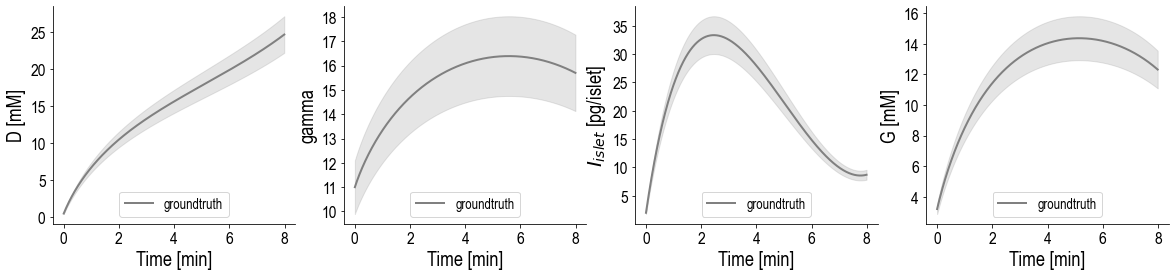

In [2]:
from InputModel.Groundtruth import *

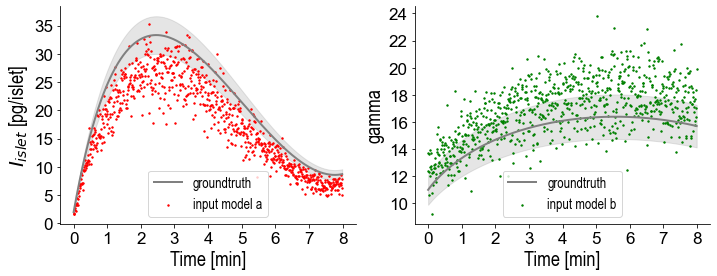

In [9]:
fig = plt.figure(figsize=(18, 4))

ax = fig.add_subplot(1, 3, 1)

plt.yticks(fontproperties = 'Arial', size = 17)
plt.xticks(fontproperties = 'Arial', size = 17)
ax=plt.gca()  
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('Time [min]', fontproperties = 'Arial Narrow', size = 20)
plt.ylabel(model_var_gt[2], fontproperties = 'Arial Narrow', size = 20)

time = np.arange(0, sim_time_gt, dt_gt)
plt.plot(time, groundtruth[:, 2], color='grey', linewidth=2, label='groundtruth') 
plt.fill_between(time,(groundtruth[:, 2] - groundtruth_std[:, 2]).reshape(-1,), 
                 (groundtruth[:, 2] + groundtruth_std[:, 2]).reshape(-1,), alpha=0.2, color='grey')

biased_obs1 = np.array([np.random.normal(0.8, 0.1)*groundtruth[i, 2] for i in range(len(groundtruth))])

plt.scatter(time, biased_obs1, color='red', s=2, label='input model a') 
plt.legend(loc='lower center', prop={'size': 14, 'family': 'Arial Narrow'})



ax = fig.add_subplot(1, 3, 2)

plt.yticks(fontproperties = 'Arial', size = 17)
plt.xticks(fontproperties = 'Arial', size = 17)
ax=plt.gca()  
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.xlabel('Time [min]', fontproperties = 'Arial Narrow', size = 20)
plt.ylabel(model_var_gt[1], fontproperties = 'Arial Narrow', size = 20)

time = np.arange(0, sim_time_gt, dt_gt)
plt.plot(time, groundtruth[:, 1], color='grey', linewidth=2, label='groundtruth') 
plt.fill_between(time,(groundtruth[:, 1] - groundtruth_std[:, 1]).reshape(-1,), 
                 (groundtruth[:, 1] + groundtruth_std[:, 1]).reshape(-1,), alpha=0.2, color='grey')

biased_obs2 = np.array([np.random.normal(1.1, 0.1)*groundtruth[i, 1] for i in range(len(groundtruth))])
plt.scatter(time, biased_obs2, color='green', s=2, label='input model b') 
plt.legend(loc='lower center', prop={'size': 14, 'family': 'Arial Narrow'})


plt.show()

### Input model a: body model

The body model describes the change of extracellular glucose concentration ($D_t^a$) as the change of insulin secretion amount of an islet ($I_{islet, t}^a$) as a function of time. 

$$\begin{aligned}
\frac{dD^a}{dt} &= k^a_1log({I_{islet,t-1}^a}) + k^a_2 \\
\frac{dI_{islet}^a}{dt} &= k^a_3(D_{t-1}^a)^2 + k^a_4 D_{t-1}^a + k^a_5
\end{aligned}$$

In [5]:
from InputModel.Subsystem import *

In [10]:
print(dt_a)

0.05


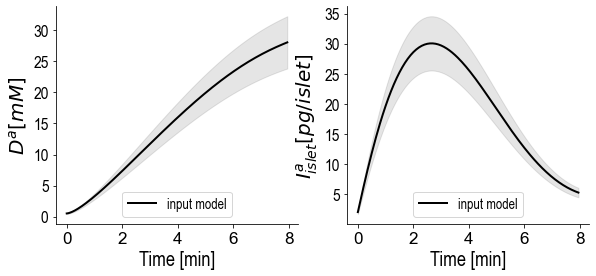

In [6]:
plot_inputmodel(input_a, input_std=input_a_std, dt=dt_a, sim_time=sim_time_a, name=model_var_a)

### Input model b: $\beta$-cell model

The $\beta$-cell model describes the change of insulin secretion amount of a single cell ($I_{cell,t}^b$) as a function of time, $\beta$-cell activity ($\gamma_t^b$) and the plasma glucose concentration ($G_t^b$).  

$$\begin{aligned}
\frac{dG^b}{dt} &= k^b_1I_{cell, t-1}^b + k^b_2(\gamma_{t-1}^b)^{2/3} + k^b_3 \\
\frac{dI_{cell}^b}{dt} &= k^b_4\gamma_{t-1}^b + k^b_5G_{t-1}^b + k^b_6\\
\frac{d\gamma^b}{dt} &= k^b_7(I_{cell, t-1}^b)^2 + k^b_8 \\
\end{aligned}$$

In [11]:
print(dt_b)

0.01


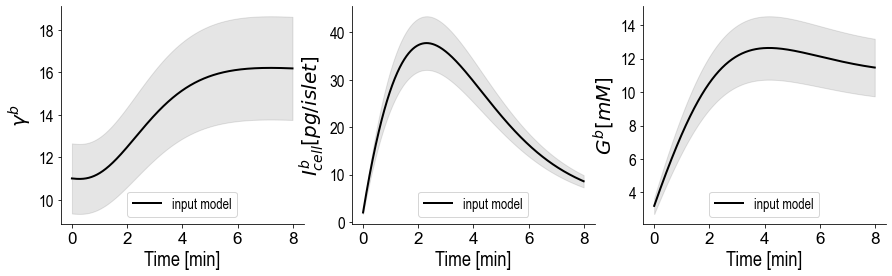

In [7]:
plot_inputmodel(input_b, input_std=input_b_std, dt=dt_b, sim_time=sim_time_b, name=model_var_b)

As you may have noticed, each input model provides a biased observation compared with the groundtruth.  We hope GraphMM can construct a metamodel which provides more accurate and precise estimations for the model variables.

## B. Incorporate input models of high-complexity via Bayesian filters <a id="surrogate"></a>

As we mentioned above, we apply state space model to surrogate the input model. A series of methods can be applied to implement a state space model. Here, we choose [Unscented Kalman Filter](https://en.wikipedia.org/wiki/Kalman_filter#Unscented_Kalman_filter) (UKF). The process model is assumed as a list of time-discrete equations approximated from input model ODEs. The observation model is defined as an identity matrix for simplification. Thus, the transition function $f$ in the process model and the emission function $h$ in the observation model are known. The process noise $e_t^{pr}$ and observation noise $e_t^{obs}$ are assumed as zero-mean Gaussian distributions with covariance matrices $Q_t$ and $R_t$, respectively. Given these assumptions, the input model can be converted into a time-discrete nonlinear dynamic state space model as:

$$Z_t = f(Z_{t-1}) + e_t^{pr}, e_t^{pr} \sim N(0, Q_t)$$

$$O_t = h(Z_t) + e_t^{obs}, e_t^{obs} \sim N(0, R_t) $$

where $Z_t$ represents a vector of state variables in the process model at time slice $t$, and $O_t$ is the a vector of measurements at time slice $t$. More details about state space model and UKF can be found [here](https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python). Specifically, state variables in each input model denotes:
$$Z_t^a = \begin{bmatrix} D_t^a \\ I_t^a \end{bmatrix}, 
Z_t^b = \begin{bmatrix}  G_t^b  \\ I_t^b  \\ \gamma_t^b \end{bmatrix}$$

Now, we illustrate how to surrogate the input model step by step. We use the input model b as an example.

First, we specify functions in the process model <strong>```fx```</strong> using equations in the input model.

```python
def fx_model_b(x, dt):
    
    xout = np.empty(x.shape)
    
    para = [-0.012033662331178321, 
            -2.562629508906522, 
            16.80173878324375, 
            2.766025041232098, 
            -5.838514397004378, 
            24.751821726759008, 
            0.0013589163544795641, 
            -0.04609297291391046]
    
    xout[0] = x[0] + dt*(para[6]*x[1]**2 + para[7])
    xout[1] = x[1] + dt*(para[3]*x[0] + para[4]*x[2] + para[5])
    xout[2] = x[2] + dt*(para[0]*x[1] + para[1]*x[0]**(2/3) + para[2])
    
    return xout
```

Next, we get measurements of the state variables from experimental datasets. Since the toy input models are synthetic, we assume the obeservations as samples drawn from the values of [groundtruth](#synthetic_groundtruth) with random gaussian noises.

```python
measure_std_scale = 1e-3
observations_b = get_observations([gamma_0, I_0, G_0], fx_model_b, dt_b, sim_time_b, measure_std_scale)
```

Then, we define parameters in the surrogate model, including initial state $Z_0$, covariance matrices $Q_t$ and $R_t$. Both of the two matrices are time-invariant. In real cases, the noise models can be obtained from prior knowledge. Here, we apply synthetic noises from input model results and observations instead. 
```python
transition_cov_scale = 0.1
emission_cov_scale = 0.1
Q_b = [np.diag(np.mean(input_b, axis=0)*transition_cov_scale) for i in range(n_step_b)]
R_b = [np.diag(np.mean(input_b, axis=0)*emission_cov_scale) for i in range(n_step_b)]
```

Now, we perform model inference over the surrogate model.
```python
surrogate_b = SurrogateInputModel(name='model_b',
                                  state=model_var_b, 
                                  initial=[gamma_0, I_0, G_0], 
                                  initial_noise=input_b[1][0], 
                                  fx=fx_model_b, Q=Q_b, R=R_b, 
                                  obs=observations_b, 
                                  dt=dt_b, total_time=sim_time_b, unit='min')
surrogate_b.inference(n_repeat=10)
```

-------- generating observations ----------
[////////////////////////////////////////////////////////////////////////////////////////////////////]100%
observations_shape:(800, 3, 2)
******** Metamodel info ********
model_name: model_b
total_sim_time: 8 min
time_step: 0.01 min
num_repeat: 1
******** Metamodel info ********
-------- Run surrogate model ---------
[////////////////////////////////////////////////////////////////////////////////////////////////////]100%
 -------- Finished ---------


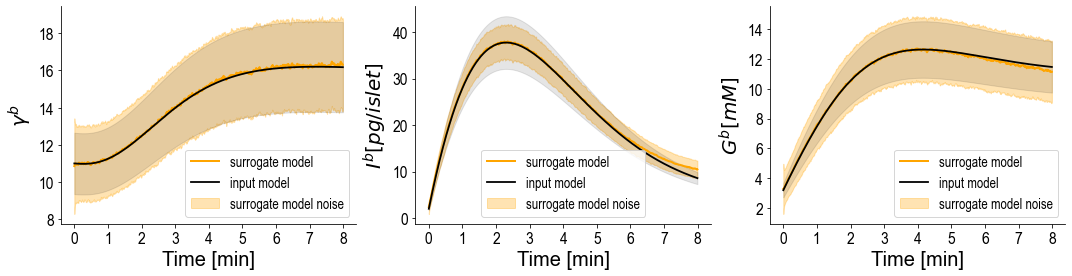

In [5]:
from GraphMetamodel.SurrogateModel import *
from Surrogate_model_b import *

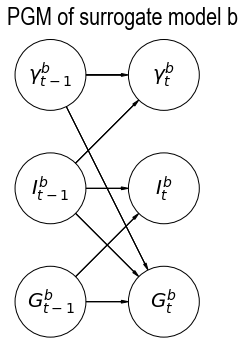

In [28]:
from matplotlib import rc
import daft

rc("font", family="Arial Narrow", size=20)

pgm_b = daft.PGM([4,5.5],node_unit=2.5)

pgm_b.add_node(daft.Node("gamma_t_1",r"$\gamma_{t-1}^b$",1,3),fontsize = 20)
pgm_b.add_node(daft.Node("gamma_t",r"$\gamma_t^b$",3,3),fontsize = 20)
pgm_b.add_node(daft.Node("i_t_1",r"$I_{t-1}^b$",1,1),fontsize = 20)
pgm_b.add_node(daft.Node("i_t",r"$I_{t}^b$",3,1),fontsize = 20)
pgm_b.add_node(daft.Node("g_t_1",r"$G_{t-1}^b$",1,-1),fontsize = 20)
pgm_b.add_node(daft.Node("g_t",r"$G_{t}^b$",3,-1),fontsize = 20)

pgm_b.add_edge("gamma_t_1","gamma_t")
pgm_b.add_edge("i_t_1","i_t")
pgm_b.add_edge("g_t_1","g_t")
pgm_b.add_edge("g_t_1","i_t")
pgm_b.add_edge("gamma_t_1","g_t")
pgm_b.add_edge("i_t_1","gamma_t")
pgm_b.add_edge("i_t_1","g_t")

pgm_b.render()
plt.title('PGM of surrogate model b')
plt.show()

Similarly, we convert input model a into a surrogate model.

-------- generating observations ----------
[////////////////////////////////////////////////////////////////////////////////////////////////////]100%
observations_shape:(160, 2, 2)
******** Metamodel info ********
model_name: model_a
total_sim_time: 8 min
time_step: 0.05 min
num_repeat: 1
******** Metamodel info ********
-------- Run surrogate model ---------
[////////////////////////////////////////////////////////////////////////////////////////////////////]100%
 -------- Finished ---------


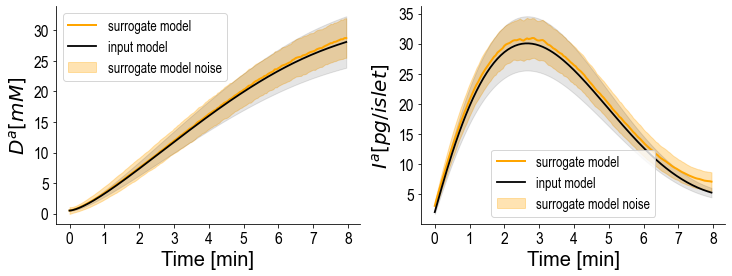

In [6]:
from Surrogate_model_a import *

surrogate_a = run_surrogate_model_a(method='MultiScale')

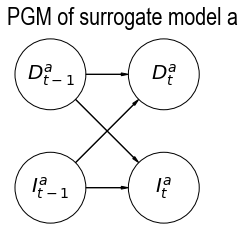

In [30]:
pgm_a = daft.PGM([4,3.5],node_unit=2.5)

pgm_a.add_node(daft.Node("d_t_1",r"$D_{t-1}^a$",1,3),fontsize = 20)
pgm_a.add_node(daft.Node("d_t",r"$D_t^a$",3,3),fontsize = 20)
pgm_a.add_node(daft.Node("i_t_1",r"$I_{t-1}^a$",1,1),fontsize = 20)
pgm_a.add_node(daft.Node("i_t",r"$I_{t}^a$",3,1),fontsize = 20)

pgm_a.add_edge("d_t_1","d_t")
pgm_a.add_edge("i_t_1","i_t")
pgm_a.add_edge("i_t_1","d_t")
pgm_a.add_edge("d_t_1","i_t")

pgm_a.render()
plt.title('PGM of surrogate model a')
plt.show()

## C. Couple surrogate models via a standardized and automated coupling graph<a id="coupling"></a>

Biological events are highly dynamic, interdependent and complicated. Each biological model can only shed light to a small subset of them. No single model can descibe an entire biological event thoroughly and comprehensively. Fortunately, most biological events share related variables which reflect the same biological process. This offers us opportunities to couple individual models together into a whole cell map. Naturally, the input models can also restrain mutually.

As you may have noticed, the two input models above share the same variable: insulin secretion amount of a single islet. Intuitively, the two toy models can be coupled together through the shared variable according to their interdependence in biological senmantics. Here, we define a standardized and automated coupling scheme to relate different input models. This makes sure the coupling of input models more efficiently and systematically instead of in an *ad hoc* manner. 

### C.1 Principle of model integration through explicit coupling variables using recursive Bayesian filtering

In principle, $P(M_1,M_2) = \int_C P(M_1,M_2,C) dC$, which means an expilicit coupling variable provides a more detailed explanation of the restraints between two models. More desciptions and explanations about the coupling scheme can be found in the [manuscript](https://docs.google.com/document/d/1As6r7BHpusFLq-kf93c0CriRXehjhiNq5bjUWHBo-98/edit?usp=sharing).

For explicit coupling variables, we aim to maintain a joint distribution over all variables in the coupling graph of each timeslice and perform model inference along time at the same time, specifically, for 2 models, we aim to obtain $p(\mathbf{Z_t^1}|O_{1:t}^1, O_{1:t}^2)$ and $p(\mathbf{Z_t^2}|O_{1:t}^1, O_{1:t}^2)$.

$$\begin{aligned}
p(\mathbf{Z_t}|O_{1:t}^1, O_{1:t}^2) &\propto  p(\mathbf{Z_t}, O_t^1, O_t^2|O_{1:t-1}^1, O_{1:t-1}^2) \\
&= \int_{\mathbf{Z_{t-1}}} \int_{y_t} p(y_t, \mathbf{Z_t}, \mathbf{Z_{t-1}}, O_t^1, O_t^2|O_{1:t-1}^1, O_{1:t-1}^2)  dy_t d\mathbf{Z_{t-1}} \\
&= \int_{\mathbf{Z_{t-1}}} \left[ \int_{y_t} p(\mathbf{Z_t}, y_t|\mathbf{Z_{t-1}}) dy_t \right]  p(O_t^1, O_t^2|\mathbf{Z_t}) p(\mathbf{Z_{t-1}}|O_{1:t-1}^1, O_{1:t-1}^2) d\mathbf{Z_{t-1}} \text{ or}\\ 
\end{aligned}$$

Here, the conditional PDF $p(\mathbf{Z_t}, y_t|\mathbf{Z_{t-1}})$ determines how coupling variable affect the input models, and how input models affect each other, this is defined by the user, and can be various. 

### C.2 Parameterize the coupling graph
To maximize contextualization among the input models, we apply the information reflecting the conflicts of models (e.g., the overlap of model variable PDFs) to approximate the parameters in the coupling graph. Here, we define a heuristic function for the parameters to fit in this demand. Specifically, one example is we search for parameter $\omega_t^{(i)}$ and $\varphi_t^{(i)}$ in the conditional PDF $p(y_t^{(i)}|y_t, x_{t-1}^{(i)}, y_{t-1}^{(i)}) = N(\omega_t^{(i)} f_{t,y}^{(i)}  + (1 - \omega_t^{(i)})\hat {y_t}, \varphi_t^{(i)})$ to make sure that $p(y_t^{(i)}|O_{1:t}^1, O_{1:t}^2) \propto$ the overlap area of the PDF of two connecting variables. 

In this specific example, we add two conditional PDFs to couple the two models: $p(I_t^a | I_t)$ and $p(I_t^b | I_t)$. Besides, we specify the marginal distribution of $I^t$ as $p(I^t)$ for a complete probabilistic graph.
As a result, the conditional PDFs over the variable $I_t^a$ changes to $p(I_t^a | I_t, I_{t-1}^a, D_{t-1}^a)$, and it the same for the variable $I_t^b$.

Since we assume the conditional PDF $p(I_t^a | I_t, I_{t-1}^a, D_{t-1}^a)$ as a Guassian PDF, we need to parameterize the mean value and variance of this conditional PDF before we perform model inference.

$p(I_t^a | I_t, I_{t-1}^a, D_{t-1}^a) = N(\omega_t f^a(I_{t-1}^a, D_{t-1}^a)  + (1 - \omega_t) I_t, \varphi_t)$ 

In [7]:
from GraphMetamodel.DefineCouplingGraph import *

In [8]:
Coupling_graph = coupling_graph(models = {'a_b':(surrogate_a, surrogate_b)}, 
                                connect_var = {'a_b':('$I^a [pg/islet]$', '$I^b [pg/islet]$')}, 
                                unit_weights = [[1,1]], 
                                w_phi=1, w_omega=1, w_epsilon=1) # the parameters are adjustable

In [9]:
Coupling_graph.get_coupling_graph_multi_scale()
Coupling_graph.get_upd_coupling_graph_multi_scale()

******** Coupling Graph info ********
===== Sub-coupling graph =====
model_one_name: model_a
connecting_variable: $I^a [pg/islet]$
model_two_name: model_b
connecting_variable: $I^b [pg/islet]$
overlap steps: 160
******** Coupling Graph info ********


Next, we illustrate how the surrogate models are coupled together through our standardized and automated coupling scheme, examplified with the two input models introduced above. The selected connecting variable is $I$, corresponding to a PGM as:

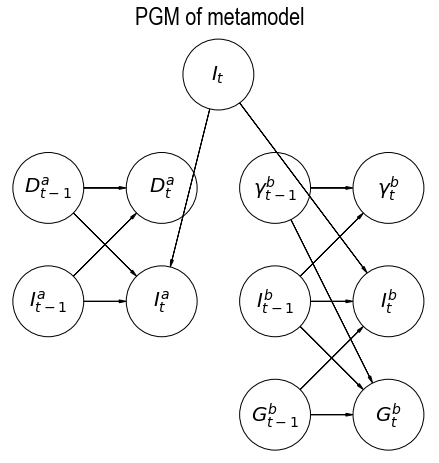

In [34]:
pgm_meta = daft.PGM([7.5,7.5],node_unit=2.5)

pgm_meta.add_node(daft.Node("gamma_t_1",r"$\gamma_{t-1}^b$",5,3))
pgm_meta.add_node(daft.Node("gamma_t",r"$\gamma_t^b$",7,3))
pgm_meta.add_node(daft.Node("i_t_1_b",r"$I_{t-1}^b$",5,1))
pgm_meta.add_node(daft.Node("i_t_b",r"$I_{t}^b$",7,1))
pgm_meta.add_node(daft.Node("g_t_1",r"$G_{t-1}^b$",5,-1))
pgm_meta.add_node(daft.Node("g_t",r"$G_{t}^b$",7,-1))
pgm_meta.add_node(daft.Node("d_t_1",r"$D_{t-1}^a$",1,3))
pgm_meta.add_node(daft.Node("d_t",r"$D_t^a$",3,3))
pgm_meta.add_node(daft.Node("i_t_1_a",r"$I_{t-1}^a$",1,1))
pgm_meta.add_node(daft.Node("i_t_a",r"$I_{t}^a$",3,1))
pgm_meta.add_node(daft.Node("i_t",r"$I_{t}$",4,5))

pgm_meta.add_edge("gamma_t_1","gamma_t")
pgm_meta.add_edge("i_t_1_b","i_t_b")
pgm_meta.add_edge("g_t_1","g_t")
pgm_meta.add_edge("g_t_1","i_t_b")
pgm_meta.add_edge("gamma_t_1","g_t")
pgm_meta.add_edge("i_t_1_b","gamma_t")
pgm_meta.add_edge("i_t_1_b","g_t")
pgm_meta.add_edge("d_t_1","d_t")
pgm_meta.add_edge("i_t_1_a","i_t_a")
pgm_meta.add_edge("i_t_1_a","d_t")
pgm_meta.add_edge("d_t_1","i_t_a")
pgm_meta.add_edge("i_t","i_t_a", )
pgm_meta.add_edge("i_t","i_t_b")

pgm_meta.render()
plt.title('PGM of metamodel')
plt.show()

## D. Perform multi-timescale model inference <a id="inference"></a>

We already did Bayesian inference over the surrogate model with UKF when estimating state variables above. We do similar things for the metamodel. To integrate multi-timescale models, we need to explore a bit more in UKF and Bayesian inference so as to make a little adjustment when implementing UKF.

### D.1 Bayesian filtering and approximate inference <a id="appr_inf"></a>

Bayesian filtering aims to provide an estimation of the state variables by combining information from noisy measurements and imperfect predictions. This is expected to be more accurate than the estimation with no measurements. Estimation problems can be solved by recursively applying the ***predict–update*** cycle. In the ***predict*** step, the posterior distribution of the state variable at the previous time slice, $P(Z_{t-1}|O_{1:t-1})$, is combined with the process model that describes how the state evolves over time: 

$$P(Z_{t}|O_{1:t-1}) = \int P(Z_t|Z_{t-1})P(Z_{t-1}|O_{1:t-1}) dZ_{t-1}$$

The predicted state at time slice $t$ is referred to as the prior distribution of the state variable at the next time slice, $P(Z_{t}|O_{1:t-1})$, which represents the best guess at time $t$ given all the measurements up to the time slice $t-1$. In the ***update*** step, the measurement $O_t$ at time $t$ is used to compute the posterior distribution of the state variables using Bayes’ theorem:

$$P(Z_t | O_{1:t}) = \frac{P(O_t | Z_t)P(Z_t | O_{1:t-1})}{P(O_t | O_{1:t-1})} $$

The likelihood $P(O_t|Z_t)$ represents the conditional probability of a measurement given the predicted state, the normalizing constant $P(O_t | O_{1:t-1})$ represents the probability of the measurement. More elaborated mathematical derivations can be found in this [reference](https://ieeexplore.ieee.org/document/978374). 

Similarly, in GraphMM, we do Bayesian inference with the recursive Bayesian estimation methods. To couple two surrogate models together, we refine the original ***predict*** step into the ***predict-couple***, which means we get the predictions of the state variables and couple the state variables together at the same time. The propabilistic description of the step is:

$$P(Z_{t}|O_{1:t-1}) = \int_{Z_{t-1}} \color{red} {\int_C P(Z_t,C|Z_{t-1})dC}P(Z_{t-1}|O_{1:t-1}) dZ_{t-1}$$

The ***update*** step keeps the same as the original version. 

### D.2 Multi-timescale model inference <a id="appr_inf"></a>

We apply sequential importance sampling techniques in GraphMM to perform multi-timescale model inference. We include the coupling variable into the state space, thus we aim to compute $p(Z_t,y_t|O_{1:t}) \propto \int_{Z_{t-1}}\int_{y_{t-1}} p(Z_t,y_t|Z_{t-1})p(O_t|Z_t)p(Z_{t-1},y_{t-1}|O_{1:t-1}) d{y_{t-1}}dZ_{t-1}$. 

According to recursive filtering, we apply particle filtering techniques for inference. We run the each surrogate models using their own timesteps, and when its time to couple them, apply the coupling graph defined above. We obtain the marginal distribution of each model variable, instead of the joint of each updated model, but the joint of a model can also be obtained in principle.


In [26]:
import GraphMetamodel.MultiScaleInference as MSI

In [27]:
metamodel = MSI.MetaModel(Coupling_graph) 
metamodel.inference(n_particles=1000, filepath='./results/toy_metamodel_joint.csv')

******** Metamodel info ********
model_1_name: model_a
total_time: 8 min
time_step: 0.05 min
model_2_name: model_b
total_time: 8 min
time_step: 0.01 min
******** Metamodel info ********
-------- Run metamodel ---------
[////////////////////////////////////////////////////////////////////////////////////////////////////]100%
-------- Finished ----------


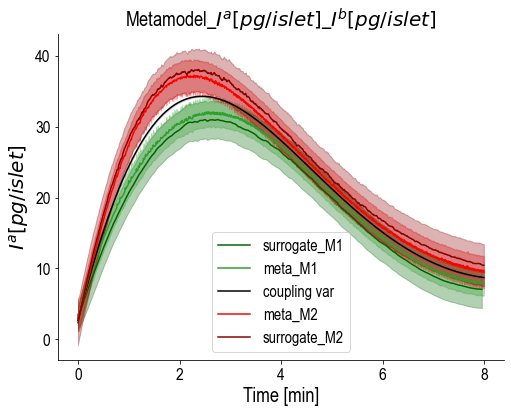

In [16]:
plot_metamodel(metamodel, model_type='GraphMM', plot_coupler=True, plot_error=True)

### D.3  Benchmark using analytical results

This is performed use single-timescale simulation.

In [10]:
import GraphMetamodel.AnalyticalSolution as analytical

In [11]:
metamodel_analytical = analytical.MetaModel(Coupling_graph) 
metamodel_analytical.inference(n_repeats=1)

-------- Run metamodel ---------
[////////////////////////////////////////////////////////////////////////////////////////////////////]100%
-------- Finished ---------


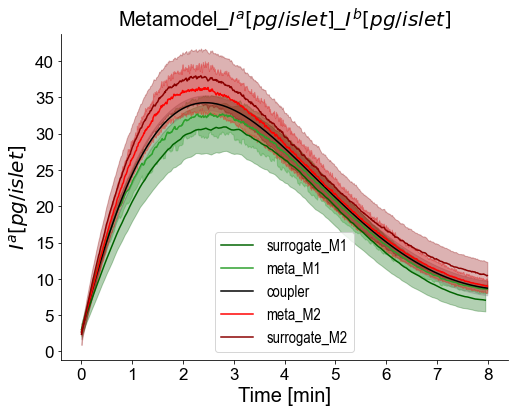

In [12]:
plot_metamodel(metamodel_analytical, model_type='analytical', plot_coupler=True, plot_error=True)

In [13]:
foutput = open('./results/toy_metamodel_analytical.csv', 'w')
print(*list(np.repeat(metamodel_analytical.state, 2)), file=foutput, sep=',')
for i in range(len(metamodel_analytical.meta_m1_mean)):
    temp_mean = metamodel_analytical.meta_m1_mean[i].tolist() + metamodel_analytical.meta_m2_mean[i].tolist()
    temp_std = metamodel_analytical.meta_m1_std[i].tolist() + metamodel_analytical.meta_m2_std[i].tolist()
    print(*list(chain.from_iterable(zip(temp_mean, temp_std))), file=foutput, sep=',')
foutput.close()

# 3. Analysis <a id="analysis"></a>

For further explanation of our results, we provide additional analyses and discussions here. We explain the functions of the coupling variables and how the coupling variables update uncertainty of input models in this part. 

## A. Model accuracy and precision <a id="model_results"></a>

### Definition of model accuracy and model precision in Bayesian metamodeling

Model error (i.e., systematic error) is defined as the deviation between the model and the ground truth. If the model variables are assumed as Gaussian random variables, model error is the difference between the means/maxima of model variable PDFs and the ground truth. Model accuracy is the degree of conformity of the model to the ground truth, estimated by model error. Model uncertainty (i.e., random error) is a measure of variability of the model, described by the spread of the model PDF (e.g., SD, SEM, and entropy). Model precision is the reciprocal of model uncertainty, which is expected to be maximized by minimizing model uncertainty.

Here, we compare the PDF of model variables before and after metamodeling to illustrate the change of model accuracy and precision.

In [20]:
def plot_normpdf(u, sig, color, name=None, label=None):
    
    x = np.linspace(u - 3*sig, u + 3*sig, 100000)
    y = np.exp(-(x - u) ** 2 / (2 * sig ** 2)) / (math.sqrt(2*math.pi)*sig)

    if name is not None:
        plt.xlabel(name, labelpad=10)
    plt.ylabel('Density', labelpad=4)
    
    ax=plt.gca()  
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    if label is not None:
        plt.plot(x, y, linestyle='-', linewidth=2, c=color, label=label) 
    else:
        plt.plot(x, y, linestyle='-', linewidth=2, c=color) 
            
    plt.fill(x, y, alpha=0.1, c=color)

In [28]:
def plot_variable_PDF(meta, timeslice):
    
    fig = plt.figure(figsize=(13, 8))

    ax = fig.add_subplot(2, 3, 1)
    plot_normpdf(groundtruth[timeslice,0], groundtruth_std[timeslice,0], 'grey')
    plot_normpdf(surrogate_a.mean[timeslice//5,0], surrogate_a.std[timeslice//5,0], 'orange')
    plot_normpdf(meta.meta_mean[timeslice,1], meta.meta_std[timeslice,1], 'red', name=r'$D_t^a [mM]$')

    ax = fig.add_subplot(2, 3, 2)
    plot_normpdf(groundtruth[timeslice,2], groundtruth_std[timeslice,2], 'grey', label='groundtruth')
    plot_normpdf(surrogate_a.mean[timeslice//5,1], surrogate_a.std[timeslice//5,1], 'orange', label='surrogate model')
    plot_normpdf(meta.meta_mean[timeslice,2], meta.meta_std[timeslice,2], 'red', name=r'$I_t^a [pg/islet]$', 
                 label='updated surrogate model')
    plt.legend(bbox_to_anchor=(1.1, .5))

    ax = fig.add_subplot(2, 3, 4)
    plot_normpdf(groundtruth[timeslice,1], groundtruth_std[timeslice,1], 'grey')
    plot_normpdf(surrogate_b.mean[timeslice,0], surrogate_b.std[timeslice,0], 'orange')
    plot_normpdf(meta.meta_mean[timeslice,3], meta.meta_std[timeslice,3], 'red', name=r'$\gamma_t^b$')

    ax = fig.add_subplot(2, 3, 5)
    plot_normpdf(groundtruth[timeslice,2], groundtruth_std[timeslice,2], 'grey')
    plot_normpdf(surrogate_b.mean[timeslice,1], surrogate_b.std[timeslice,1], 'orange')
    plot_normpdf(meta.meta_mean[timeslice,4], meta.meta_std[timeslice,4], 'red', name=r'$I_t^b [pg/islet]$')
    
    ax = fig.add_subplot(2, 3, 6)
    plot_normpdf(groundtruth[timeslice,3], groundtruth_std[timeslice,3], 'grey')
    plot_normpdf(surrogate_b.mean[timeslice,2], surrogate_b.std[timeslice,2], 'orange')
    plot_normpdf(meta.meta_mean[timeslice,5], meta.meta_std[timeslice,5], 'red', name=r'$G_t^b [mM]$')
    
    plt.subplots_adjust(hspace=0.3)
    plt.savefig('./model_var_PDF.png', dpi=600, bbox_inches = 'tight')
    plt.show()

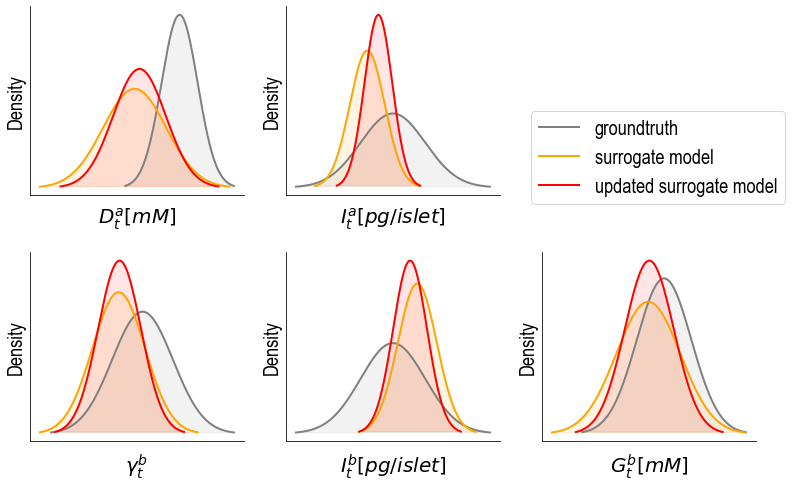

In [29]:
plot_variable_PDF(metamodel, timeslice=100)

Specially, since one of the metamodel speciality is to decrease model uncertainty by integrating more input models. Here, we compute the uncertainty (indicated by model entropy) of metamodel and each input model, so as to illustrate this speciality of metamodel.

## B. Local analysis<a id="local_analysis"></a>

To illustrate the change of model accuracy and precision concretely, we derive analytic solutions of the varaibles in each step of the ***predict-couple-update*** cycle. The expilict analytic solutions, we can be more clear about the change of the model variables when coupled and updated with BMM.

Previously, we computed the probability of all the state variables given observations $p(Z_t^a, Z_t^b|O_{1:t}^a, O_{1:t}^b)$, where $Z_t^a = [D_t \ G_t^a]^T$ and $Z_t^b = [\gamma_t \ I_t \ G_t^b]^T$. Next, we choose one step in the recyle as a local analysis because it is minimal but draws the same conclusion with global results. Besides, it is easier to derive the analytic solutions from the one step probability propagation for explanation. Specifically, we want to compare:

$$P(Z_t^a|Z_{t-1}^a, O_t^a)\text{ V.S. } P(Z_t^a|G_t^b, Z_{t-1}^a, O_t^a)$$

$$P(Z_t^b|Z_{t-1}^b, O_t^b)\text{ V.S. } P(Z_t^b|G_t^a, Z_{t-1}^b, O_t^b)$$

The first pair compares the conditional probability of state variables $Z_t^a$ at a current time slice $t$ given the last time slice $t-1$ and the observations with the conditional probability of $Z_t^a$ given the variable $G_t^a$ to be coupled in the other model at time slice $t$. Intuitively, the two probability compares the distribution of the state variables in model $a$ before and after coupling. And it is the same for the second pair.

First, we need to compute the one step probability before coupling. We split the process noise $Q_t^a$ and the observation noise $R_t^a$ in model $a$ as:

$$\begin{aligned}
Q_t^a = \begin{bmatrix} \sigma_D^a & 0\\ 0 & \sigma_G^a \end{bmatrix},
R_t^a = \begin{bmatrix} e_D^a & 0 \\ 0 & e_G^a \end{bmatrix}
\end{aligned}$$

Then the surrogate model is:

$$\begin{aligned}
\text{process model:  }p(D_t|Z_{t-1}^a) &= N(\hat D^a, \sigma_D^a), \ p(G_t^a|Z_{t-1}^a) = N(\hat G_t^a, \sigma_G^a) \\
\text{observation model:  }p(O_t^a|Z_t^a) &= N(D_t, e_D^a)N(G_t^a, e_G^a) \\ 
\end{aligned}$$

where $\hat D^a = f_D^a(Z_{t-1}^a), \hat G_t^a = f_G^a(Z_{t-1}^a)$. Then the target PDF $p(Z_t^a|Z_{t-1}^a, O_t^a)$ can be factorized as:

$$p(Z_t^a|Z_{t-1}^a, O_t^a)= p(D_t|Z_{t-1}^a)p(G_t^a|Z_{t-1}^a)p(O_t^a|Z_t^a)$$

Then we can derive the probability over the state variable $G_t^a$ as:
$$\begin{aligned}
p(G_t^a|Z_{t-1}^a, O_t^a) \propto \exp\{- \frac{\|G_t^a - W_{G_t^a}^-\|^2}{2(\omega_{G_t^a}^-)^2}\}
\end{aligned}$$

where, $\begin{aligned}
W_{G_t^a}^- =  \frac{f_G^a(e_G^a)^2 + O_t^a(\sigma_G^a)^2}{(\sigma_G^a)^2 + (e_G^a)^2}, 
\| \omega_{G_t^a}^- \|= \sqrt{\frac{(\sigma_G^a)^2(e_G^a)^2}{(\sigma_G^a)^2 + (e_G^a)^2}}\\
\end{aligned}$. The superscript denotes variables before coupling.

Similarly for model $b$, we can also derive the probability over the state variables $G_t^b$ as:
$$\begin{aligned}
p(G_t^b|Z_{t-1}^b, O_t^b) \propto \exp\{- \frac{\|G_t^b - W_{G_t^b}^-\|^2}{2(\omega_{G_t^b}^-)^2}\}
\end{aligned}$$

where $\begin{aligned}
W_{G_t^b}^- =  \frac{f_G^b(e_G^b)^2 + O_t^b(\sigma_G^b)^2}{(\sigma_G^b)^2 + (e_G^b)^2}, 
\| \omega_{G_t^b}^- \|= \sqrt{\frac{(\sigma_G^b)^2(e_G^b)^2}{(\sigma_G^b)^2 + (e_G^b)^2}}\\
\end{aligned}$

Next, we compute the one step probability after coupling. The target PDF $p(Z_t^a|G_t^b, Z_{t-1}^a, O_t^a)$ and $p(Z_t^b|G_t^a, Z_{t-1}^b, O_t^b)$ can also be factorized as:

$$p(Z_t^a|G_t^b, Z_{t-1}^a, O_t^a) = \color{red} {\int p(G_t|G_t^a) p(G_t^b|G_t, Z_{t-1}^b) dG_t} p(Z_t^a|Z_{t-1}^a) p(O_t^a|Z_t^a)$$
$$p(Z_t^b|G_t^a, Z_{t-1}^b, O_t^b) = \color{red} {\int p(G_t|G_t^a) p(G_t^b|G_t, Z_{t-1}^b) dG_t} p(Z_t^b|Z_{t-1}^b) p(O_t^b|Z_t^b)$$

Then we can derive the probability over the state variable $G_t^a$ and $G_t^b$ (after coupling) as:
$$\begin{aligned}
p(G_t^a|G_t^b, Z_{t-1}^a, O_t^a) \propto \exp\{- \frac{\|G_t^a - W_{G_t^a}\|^2}{2(\omega_{G_t^a})^2}\}, 
p(G_t^b|G_t^a, Z_{t-1}^b, O_t^b) \propto \exp\{- \frac{\|G_t^b - W_{G_t^b}\|^2}{2(\omega_{G_t^b})^2}\}
\end{aligned}$$

where, $\begin{aligned}
W_{G_t^a} &= \frac{(1-\omega)(G_t^b - \omega \hat G_t^b)(\sigma_G^a)^2(e_G^a)^2+\lambda \hat G_t^a(\sigma_G^a)^2 + \lambda O_t^a(e_G^a)^2}{(1-\omega)^2(\sigma_G^a)^2(e_G^a)^2+\lambda(\sigma_G^a)^2 + \lambda(e_G^a)^2}, 
\|\omega_{G_t^a}\| = \sqrt{\frac{\lambda(\sigma_G^a)^2(e_G^a)^2}{(1-\omega)^2(\sigma_G^a)^2(e_G^a)^2+\lambda(\sigma_G^a)^2 + \lambda(e_G^a)^2}}, \\
W_{G_t^b} &= \frac{(\omega \hat G_t^b + (1 - \omega)G_t^a)(e_G^b)^2 + \lambda O_t^b}{\lambda+(e_G^b)^2}, 
\| \omega_{G_t^b}\| = \sqrt{\frac{\lambda(e_G^b)^2}{\lambda + (e_G^b)^2}}, \lambda = \varphi^2 + \epsilon^2(1-\omega)^2
\end{aligned}$

Now, let's can compare the results:

$\begin{aligned}
\frac{\|\omega_{G_t^a}^-\|} {\|\omega_{G_t^a}\|} 
&= \sqrt{\frac{(1-\omega)^2(\sigma_G^a)^2(e_G^a)^2+\lambda(\sigma_G^a)^2 + \lambda(e_G^a)^2}{\lambda(\sigma_G^a)^2 + \lambda(e_G^a)^2}} \\
\end{aligned}$

$\begin{aligned}\text{Since } \frac{\|\omega_{G_t^a}^-\|} {\|\omega_{G_t^a}\|} > 1, \end{aligned}$ the uncertainty of state variable $G_t^a$ always decreases after coupling.

$\begin{aligned}
\frac{\|\omega_{G_t^b}^-\|} {\|\omega_{G_t^b}\|} 
&= \sqrt{\frac{\lambda (\sigma_G^b)^2 + (\sigma_G^b)^2 (e_G^b)^2}{\lambda (\sigma_G^b)^2 + \lambda (e_G^b)^2}}, \lambda = \varphi^2 + \epsilon^2(1-\omega)^2
\end{aligned}$

$\text{If and only if } (\sigma_G^b)^2 > \lambda,$ the uncertainty of state variable $G_t^b$ decreases after coupling.

For model $a$, the uncertainty of state variable $G_t^a$ always decreases since information from model $b$ update the uncertainty as an additional observation. This is beacause it is the parent node in the **serial** coupling topology. However, the change of the uncertainty of state variable $G_b^a$ depends on parameters in the coupling variable. 

Similar analysis for the other two topologies can be found in [supplementary materials](https://docs.google.com/document/d/1As6r7BHpusFLq-kf93c0CriRXehjhiNq5bjUWHBo-98/edit#heading=h.3aeeaqe95not).

# 4. Summary and outlook<a id="summary"></a>

For illustration purposes, we used a lot of gaussian distribution assmptions here. But in real cases, the distributions of many biological variables are unknown and intractable. Fortunately, there are numerous methods to deal with the problem using approximation methods. We will also keep updating the methods with more applications. More questions please contact chenxi.wang@salilab.org

## References: <a id="refer"></a>

1. M. S. Arulampalam, S. Maskell, N. Gordon, T. Clapp, A tutorial on particle filters for online nonlinear/non-Gaussian Bayesian tracking. IEEE Transactions on Signal Processing 50, 174–188 (2002).
2. H. W. Sorenson, Kalman Filtering: Theory and Application (IEEE, 1985).
3. M. de Apráiz, M. de Apráiz, R. Diego, J. Barros, An Extended Kalman Filter Approach for Accurate Instantaneous Dynamic Phasor Estimation. Energies 11, 2918 (2018).
4. S. J. Julier, J. K. Uhlmann, New extension of the Kalman filter to nonlinear systems. Signal Processing, Sensor Fusion, and Target Recognition VI (1997) https:/doi.org/10.1117/12.280797.
5. A. Solonen, J. Hakkarainen, A. Ilin, M. Abbas, A. Bibov, Estimating model error covariance matrix parameters in extended Kalman filtering. Nonlinear Processes in Geophysics 21, 919–927 (2014).
6. J. Duník, O. Straka, O. Kost, J. Havlík, Noise covariance matrices in state-space models: A survey and comparison of estimation methods-Part I. International Journal of Adaptive Control and Signal Processing 31, 1505–1543 (2017).
7. P. S. Maybeck, The Kalman Filter: An Introduction to Concepts. Autonomous Robot Vehicles, 194–204 (1990).
8. rlabbe, rlabbe/filterpy (May 4, 2021). https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
9. J. Elfring, E. Torta, R. van de Molengraft, Particle Filters: A Hands-On Tutorial. Sensors 21, 438 (2021).